In [31]:
import pandas as pd
import spacy
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import ngrams
import re
import gensim
from gensim import corpora
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.models import Phrases
from gensim.models.phrases import Phraser 
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt
import os


### ================================ Functions ================================

def flatten(x):
    """
    Function to flatten out nested list
    
    Parameters:
    ----------
    x : nested list
    
    Return:
    ----------
    [list elements removed from nested list]
    """
    result = []
    for el in x:
        if hasattr(el, "__iter__") and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result


def tokenize(text):
    """
    Function to pre-process string 
    
    Parameters:
    ----------
    text : comment string
    Return:
    ----------
    [processed string, [list of keywords]]
    """
    ### 1. Masking common strings
    if 'https://' in text:
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'urllink', text, flags=re.MULTILINE)
    processed_text = re.sub('[^A-Za-z]+', ' ', text).lower()
    processed_text = station.sub("ttcstation", processed_text)
    processed_text = photo.sub("photo", processed_text)
    ### 2. Get Lemma and conduct POS tagging
    input_str=nlp(processed_text)
    lemma_str = [token.lemma_ for token in input_str if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
    filtered_str = [w for w in lemma_str if not w in stop_words]
    return [filtered_str]

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
### Initialise spacy
nlp = spacy.load('en_core_web_sm')
lemmatizer=WordNetLemmatizer()

### Load updated stop words list
stop_words = pd.read_csv(r'C:/thaddea.chua/stop_words.csv')
stop_words = set(stop_words['stop_words']) 

### Load station names list
station_names = pd.read_csv(r'../station_names.csv')
station = re.compile('|'.join(map(re.escape, station_names['Station'].str.lower())))

photo_names = ['svg','png','jpeg','jpg', 'photo','photos']
photo = re.compile('|'.join(map(re.escape, photo_names)))

### Load mallet package
os.environ['MALLET_HOME'] = r'../Models/mallet-2.0.8' # update this path
mallet_path = r'../Models/mallet-2.0.8/bin/mallet' # update this path

### Load data
reddit_df = pd.read_csv(r'../Data/reddit_data_raw.csv')
reddit_df.columns

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body'], dtype='object')

In [ ]:
### Pre process text 

processed_list = reddit_df['body'].apply(lambda x: tokenize(x))

text_data = [i[0] for i in processed_list]

In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(text_data, min_count=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[text_data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

############### To get uni and bigrams together
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

############### To get uni and trigrams together
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

############### To get only n-grams 
def get_n_gram(word_list, num_tokens):
    ngrams = zip(*[word_list[i:] for i in range(num_tokens)])
    return ["_".join(ngram) for ngram in ngrams]


### Pre process text - to get unigrams + bigrams only
#text_data = make_bigrams(text_data)

In [27]:
### Generate dictionary and corpus 
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus, open('../Data/corpus.pkl', 'wb'))

27482

In [30]:
### Load mallet package
os.environ['MALLET_HOME'] = r'../Models/mallet-2.0.8' # update this path
mallet_path = r'../Models/mallet-2.0.8/bin/mallet' # update this path

# Find optimal clusters
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_data, start=2, limit=40, step=8)


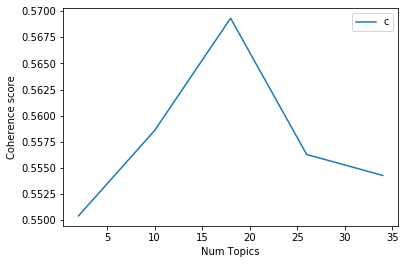

In [112]:
# Show graph coherence scores - higher score = better
limit=40; start=2; step=8;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [114]:
### Get words associated with each topic 
NUM_TOPICS = 18
NUM_WORDS = 5
ldamodel = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics= NUM_TOPICS, id2word=dictionary)
topics = ldamodel.print_topics(num_words=NUM_WORDS)
for topic in topics:
    print(topic)

(0, '0.051*"plan" + 0.043*"ford" + 0.033*"ontario" + 0.030*"project" + 0.027*"province"')
(1, '0.043*"bad" + 0.041*"problem" + 0.040*"good" + 0.040*"issue" + 0.026*"change"')
(2, '0.013*"report" + 0.011*"law" + 0.010*"company" + 0.010*"case" + 0.010*"urllink"')
(3, '0.021*"school" + 0.017*"student" + 0.017*"care" + 0.016*"kid" + 0.013*"transition"')
(4, '0.116*"bus" + 0.053*"ttc" + 0.047*"hour" + 0.044*"streetcar" + 0.042*"stop"')
(5, '0.124*"ttc" + 0.098*"subway" + 0.092*"train" + 0.054*"service" + 0.024*"track"')
(6, '0.286*"transit" + 0.114*"city" + 0.078*"toronto" + 0.068*"public" + 0.022*"option"')
(7, '0.020*"guy" + 0.019*"call" + 0.019*"happen" + 0.018*"police" + 0.017*"back"')
(8, '0.055*"cost" + 0.049*"pay" + 0.046*"money" + 0.029*"tax" + 0.022*"increase"')
(9, '0.088*"car" + 0.056*"drive" + 0.037*"driver" + 0.035*"road" + 0.033*"traffic"')
(10, '0.047*"area" + 0.040*"build" + 0.032*"toronto" + 0.029*"downtown" + 0.025*"city"')
(11, '0.263*"ttcstation" + 0.121*"subway" + 0.030

In [117]:
#ldamodel = gensim.models.ldamodel.LdaModel.load('..\Models\model5.gensim')

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamodel)
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, r'../Visualisations/visualisation.html')


C:\Users\thaddea.chua\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\thaddea.chua\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\thaddea.chua\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\thaddea.chua\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.con